1

In [1]:
import os, json, random, warnings, math, time
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler

from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATv2Conv, global_mean_pool, global_max_pool, LayerNorm

from rdkit import Chem
from rdkit.Chem import rdchem
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import AllChem

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import joblib
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")


2

In [2]:
SEED = 42
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.set_float32_matmul_precision("high")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

use_amp = (device.type == "cuda")
if use_amp and torch.cuda.is_available():
    # Prefer bf16 when supported, else fp16
    bf16_ok = torch.cuda.is_bf16_supported()
    amp_dtype = torch.bfloat16 if bf16_ok else torch.float16
else:
    amp_dtype = None

print("AMP:", use_amp, "dtype:", amp_dtype)


Device: cuda
Torch: 2.1.2+cu121
CUDA available: True
AMP: True dtype: torch.bfloat16


3

In [58]:
FILE_PATH = "drugbank.tab"
df = pd.read_csv(FILE_PATH, sep="\t")
print("Raw samples:", len(df), "| Raw classes:", df["Y"].nunique())

# If labels are 1..K, shift to 0..K-1
if df["Y"].min() >= 1:
    df["Y"] -= 1

# Filter rare classes (avoid tiny classes breaking training)
MIN_SAMPLES = 20
vc = df["Y"].value_counts()
keep = vc[vc >= MIN_SAMPLES].index
df = df[df["Y"].isin(keep)].copy()
print("After min-samples filter:", len(df), "| classes:", df["Y"].nunique())

def valid_smiles(s):
    return Chem.MolFromSmiles(str(s)) is not None

df = df[df["X1"].apply(valid_smiles) & df["X2"].apply(valid_smiles)].reset_index(drop=True)
print("After SMILES valid filter:", len(df), "| classes:", df["Y"].nunique())


Raw samples: 191808 | Raw classes: 86
After min-samples filter: 191700 | classes: 76
After SMILES valid filter: 191700 | classes: 76


4

In [59]:
def get_scaffold_safe(smiles: str):
    m = Chem.MolFromSmiles(str(smiles))
    if m is None:
        return None
    scaf = MurckoScaffold.MurckoScaffoldSmiles(mol=m) or ""
    if scaf.strip():
        return scaf
    # fallback for acyclic molecules
    return "ACYCLIC::" + Chem.MolToSmiles(m, isomericSmiles=True)

def pair_key(a: str, b: str):
    # order-invariant: A||B == B||A
    return "||".join(sorted((a, b)))

df["scaf1"] = df["X1"].apply(get_scaffold_safe)
df["scaf2"] = df["X2"].apply(get_scaffold_safe)
df = df[df["scaf1"].notna() & df["scaf2"].notna()].reset_index(drop=True)
df["pair_scaffold"] = [pair_key(a, b) for a, b in zip(df["scaf1"], df["scaf2"])]

print("Unique pair scaffolds:", df["pair_scaffold"].nunique())


Unique pair scaffolds: 99033


5

In [60]:
groups = df.groupby("pair_scaffold").indices
scaffolds = list(groups.keys())

rng = np.random.default_rng(SEED)
rng.shuffle(scaffolds)

n_total = len(scaffolds)
n_test = int(0.10 * n_total)
n_val  = int(0.10 * n_total)

test_scaf = set(scaffolds[:n_test])
val_scaf  = set(scaffolds[n_test:n_test+n_val])

train_idx, val_idx, test_idx = [], [], []
for scaf, idxs in groups.items():
    idxs = idxs.tolist() if hasattr(idxs, "tolist") else list(idxs)
    if scaf in test_scaf:
        test_idx += idxs
    elif scaf in val_scaf:
        val_idx += idxs
    else:
        train_idx += idxs

train_df = df.iloc[train_idx].reset_index(drop=True)
val_df   = df.iloc[val_idx].reset_index(drop=True)
test_df  = df.iloc[test_idx].reset_index(drop=True)

print("Train:", len(train_df), "Val:", len(val_df), "Test:", len(test_df))

train_sc = set(train_df["pair_scaffold"])
val_sc   = set(val_df["pair_scaffold"])
test_sc  = set(test_df["pair_scaffold"])

assert train_sc.isdisjoint(val_sc), "Leakage: train/val scaffold overlap"
assert train_sc.isdisjoint(test_sc), "Leakage: train/test scaffold overlap"
assert val_sc.isdisjoint(test_sc), "Leakage: val/test scaffold overlap"

print("Leakage proof: disjoint pair_scaffold across splits")
print("Scaffold counts:", {"train": len(train_sc), "val": len(val_sc), "test": len(test_sc)})


Train: 153900 Val: 18387 Test: 19413
Leakage proof: disjoint pair_scaffold across splits
Scaffold counts: {'train': 79227, 'val': 9903, 'test': 9903}


6

In [61]:
train_labels = set(train_df["Y"].unique())
val_labels   = set(val_df["Y"].unique())
test_labels  = set(test_df["Y"].unique())

missing_in_train = (val_labels | test_labels) - train_labels
if len(missing_in_train) > 0:
    print("Dropping labels missing in TRAIN:", sorted(list(missing_in_train)))
    # Only filter VAL/TEST by train labels (train already defines train_labels)
    val_df  = val_df[val_df["Y"].isin(train_labels)].reset_index(drop=True)
    test_df = test_df[test_df["Y"].isin(train_labels)].reset_index(drop=True)

# Remap labels based on TRAIN only to [0..C-1]
label_map = {old:i for i, old in enumerate(sorted(train_df["Y"].unique()))}
inv_label_map = {v:k for k,v in label_map.items()}

train_df["Y"] = train_df["Y"].map(label_map).astype(int)
val_df["Y"]   = val_df["Y"].map(label_map).astype(int)
test_df["Y"]  = test_df["Y"].map(label_map).astype(int)

NUM_CLASSES = int(train_df["Y"].nunique())
print(" NUM_CLASSES (train-based):", NUM_CLASSES)
print("Train label range:", train_df["Y"].min(), train_df["Y"].max())
print("Val/Test filtered sizes:", len(val_df), len(test_df))


 NUM_CLASSES (train-based): 76
Train label range: 0 75
Val/Test filtered sizes: 18387 19413


7

In [62]:
hyb_map = {
    rdchem.HybridizationType.SP: 0,
    rdchem.HybridizationType.SP2: 1,
    rdchem.HybridizationType.SP3: 2,
    rdchem.HybridizationType.SP3D: 3,
    rdchem.HybridizationType.SP3D2: 4,
}
bt_map = {
    rdchem.BondType.SINGLE: 0,
    rdchem.BondType.DOUBLE: 1,
    rdchem.BondType.TRIPLE: 2,
    rdchem.BondType.AROMATIC: 3,
}

def atom_feats(a):
    return [
        a.GetAtomicNum(),
        a.GetTotalDegree(),
        hyb_map.get(a.GetHybridization(), 5),
        int(a.GetIsAromatic()),
        a.GetFormalCharge(),
        int(a.IsInRing()),
        a.GetNumRadicalElectrons(),
        int(a.GetChiralTag()),
    ]

def bond_feats(b):
    return [bt_map.get(b.GetBondType(), 4), int(b.GetIsConjugated()), int(b.IsInRing())]

def smiles_to_graph(smiles):
    m = Chem.MolFromSmiles(str(smiles))
    if m is None:
        return None
    x = torch.tensor([atom_feats(a) for a in m.GetAtoms()], dtype=torch.float32)
    ei, ea = [], []
    for b in m.GetBonds():
        i, j = b.GetBeginAtomIdx(), b.GetEndAtomIdx()
        f = bond_feats(b)
        ei += [[i, j], [j, i]]
        ea += [f, f]
    if len(ei) == 0:
        edge_index = torch.empty((2,0), dtype=torch.long)
        edge_attr  = torch.empty((0,3), dtype=torch.float32)
    else:
        edge_index = torch.tensor(ei, dtype=torch.long).t().contiguous()
        edge_attr  = torch.tensor(ea, dtype=torch.float32)
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)


8

In [63]:
all_smiles = pd.unique(pd.concat([df["X1"], df["X2"]], axis=0))
graph_cache = {}

for s in tqdm(all_smiles, desc="Precomputing graphs"):
    g = smiles_to_graph(s)
    if g is not None:
        graph_cache[s] = g

print("Cached graphs:", len(graph_cache), "/", len(all_smiles))


Precomputing graphs: 100%|███████████████████████████████████████████████████████| 1701/1701 [00:01<00:00, 1575.35it/s]

Cached graphs: 1701 / 1701


9

In [64]:
class DDIDataset(torch.utils.data.Dataset):
    def __init__(self, frame):
        self.frame = frame.reset_index(drop=True)
        self.X1 = self.frame["X1"].tolist()
        self.X2 = self.frame["X2"].tolist()
        self.Y  = self.frame["Y"].astype(int).tolist()
    def __len__(self):
        return len(self.Y)
    def __getitem__(self, i):
        g1 = graph_cache.get(self.X1[i], None)
        g2 = graph_cache.get(self.X2[i], None)
        if g1 is None or g2 is None:
            return None
        return i, g1, g2, torch.tensor(self.Y[i], dtype=torch.long)

def collate_fn(batch):
    batch = [b for b in batch if b is not None]
    if not batch:
        return None
    idx, g1, g2, y = zip(*batch)
    return torch.tensor(idx, dtype=torch.long), Batch.from_data_list(g1), Batch.from_data_list(g2), torch.stack(y)


10

In [65]:
BATCH_SIZE = 32     
ACCUM = 2           
NUM_WORKERS = 0     
PIN_MEMORY = False
PERSISTENT = False

train_loader = DataLoader(DDIDataset(train_df), batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
                          persistent_workers=PERSISTENT, collate_fn=collate_fn)

val_loader = DataLoader(DDIDataset(val_df), batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
                        persistent_workers=PERSISTENT, collate_fn=collate_fn)

test_loader = DataLoader(DDIDataset(test_df), batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
                         persistent_workers=PERSISTENT, collate_fn=collate_fn)

print("Loaders ready.")


Loaders ready.


11

In [66]:
batch = next(iter(train_loader))
assert batch is not None, "All items None — graph_cache issue."
idx, g1, g2, y = batch
print("Sanity:", len(idx), g1.num_graphs, g2.num_graphs, y.shape, y.min().item(), y.max().item())


Sanity: 32 32 32 torch.Size([32]) 1 64


12

In [67]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = GATv2Conv(8, 64, heads=2, edge_dim=3, add_self_loops=False)
        self.n1 = LayerNorm(128)
        self.c2 = GATv2Conv(128, 64, heads=2, edge_dim=3, add_self_loops=False)
        self.n2 = LayerNorm(128)
        self.c3 = GATv2Conv(128, 64, heads=1, edge_dim=3, add_self_loops=False)
        self.n3 = LayerNorm(64)
        self.dp = nn.Dropout(0.2)

    def forward(self, g):
        x, ei, ea, b = g.x, g.edge_index, g.edge_attr, g.batch
        x = self.dp(F.elu(self.n1(self.c1(x, ei, ea))))
        x = self.dp(F.elu(self.n2(self.c2(x, ei, ea))))
        x = F.elu(self.n3(self.c3(x, ei, ea)))
        return torch.cat([global_mean_pool(x, b), global_max_pool(x, b)], dim=1)  # 128

class SiameseDDI(nn.Module):
    def __init__(self, ncls):
        super().__init__()
        self.enc = Encoder()
        self.head = nn.Sequential(
            nn.Linear(256, 128),
            nn.LayerNorm(128),
            nn.GELU(),
            nn.Dropout(0.25),
            nn.Linear(128, 96),
            nn.GELU(),
            nn.Linear(96, ncls)
        )

    def forward(self, g1, g2):
        z = torch.cat([self.enc(g1), self.enc(g2)], dim=1)  # 128+128=256
        return self.head(z)

model = SiameseDDI(NUM_CLASSES).to(device)
print("Params (M):", sum(p.numel() for p in model.parameters())/1e6)


Params (M): 0.106988


13

In [68]:
cls_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.arange(NUM_CLASSES),
    y=train_df["Y"].values
)
cls_weights = np.sqrt(cls_weights)
cls_weights = np.clip(cls_weights, 0.5, 10.0)  # stability clamp
cls_weights = torch.tensor(cls_weights, dtype=torch.float32, device=device)

class Focal(nn.Module):
    def __init__(self, gamma=2.0, weight=None):
        super().__init__()
        self.gamma = gamma
        self.weight = weight
    def forward(self, logits, target):
        ce = F.cross_entropy(logits, target, weight=self.weight, reduction="none")
        pt = torch.exp(-ce)
        return ((1-pt)**self.gamma * ce).mean()

criterion = Focal(gamma=2.0, weight=cls_weights)


14

In [69]:
optimizer = AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4, betas=(0.9, 0.98))
scheduler = ReduceLROnPlateau(optimizer, mode="max", patience=3, factor=0.5)
scaler = GradScaler(enabled=use_amp)

print("Ready.")


Ready.


15

In [70]:
def run_eval(loader):
    model.eval()
    yt, yp = [], []
    with torch.no_grad():
        for batch in loader:
            if batch is None:
                continue
            idx, g1, g2, y = batch
            g1 = g1.to(device, non_blocking=True)
            g2 = g2.to(device, non_blocking=True)
            with autocast(enabled=use_amp, dtype=amp_dtype):
                out = model(g1, g2)
            yt.extend(y.tolist())
            yp.extend(out.argmax(1).detach().cpu().tolist())
    return f1_score(yt, yp, average="weighted"), accuracy_score(yt, yp)


16

In [18]:
EPOCHS = 30          
PATIENCE = 6
best_val_f1 = 0.0
bad = 0

start = time.time()
for epoch in range(1, EPOCHS+1):
    model.train()
    optimizer.zero_grad(set_to_none=True)
    total_loss = 0.0
    steps = 0

    for step, batch in enumerate(tqdm(train_loader, desc=f"Train {epoch}/{EPOCHS}")):
        if batch is None:
            continue
        idx, g1, g2, y = batch
        g1 = g1.to(device, non_blocking=True)
        g2 = g2.to(device, non_blocking=True)
        y  = y.to(device, non_blocking=True)

        with autocast(enabled=use_amp, dtype=amp_dtype):
            logits = model(g1, g2)
            loss = criterion(logits, y) / ACCUM

        scaler.scale(loss).backward()

        if (step + 1) % ACCUM == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)

        total_loss += float(loss.item()) * ACCUM
        steps += 1

    val_f1, val_acc = run_eval(val_loader)
    scheduler.step(val_f1)

    print(f"Epoch {epoch:02d} | train_loss {total_loss:.2f} | val_acc {val_acc:.4f} | val_f1 {val_f1:.4f}")

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        bad = 0
        torch.save(model.state_dict(), "ddi_best.pt")
        print("  saved ddi_best.pt")
    else:
        bad += 1
        if bad >= PATIENCE:
            print(" early stopping")
            break

print("Training minutes:", (time.time()-start)/60)
print("Best Val F1:", best_val_f1)


Train 1/30: 100%|██████████████████████████████████████████████████████████████████| 4810/4810 [02:08<00:00, 37.47it/s]


Epoch 01 | train_loss 6536.87 | val_acc 0.3536 | val_f1 0.3109
  saved ddi_best.pt


Train 2/30: 100%|██████████████████████████████████████████████████████████████████| 4810/4810 [02:09<00:00, 37.03it/s]


Epoch 02 | train_loss 5253.83 | val_acc 0.4323 | val_f1 0.4075
  saved ddi_best.pt


Train 3/30: 100%|██████████████████████████████████████████████████████████████████| 4810/4810 [02:13<00:00, 35.90it/s]


Epoch 03 | train_loss 4420.67 | val_acc 0.4523 | val_f1 0.4359
  saved ddi_best.pt


Train 4/30: 100%|██████████████████████████████████████████████████████████████████| 4810/4810 [02:11<00:00, 36.45it/s]


Epoch 04 | train_loss 3811.27 | val_acc 0.4915 | val_f1 0.4691
  saved ddi_best.pt


Train 5/30: 100%|██████████████████████████████████████████████████████████████████| 4810/4810 [02:13<00:00, 36.06it/s]


Epoch 05 | train_loss 3387.56 | val_acc 0.5402 | val_f1 0.5321
  saved ddi_best.pt


Train 6/30: 100%|██████████████████████████████████████████████████████████████████| 4810/4810 [02:13<00:00, 36.11it/s]


Epoch 06 | train_loss 3020.34 | val_acc 0.5656 | val_f1 0.5566
  saved ddi_best.pt


Train 7/30: 100%|██████████████████████████████████████████████████████████████████| 4810/4810 [02:10<00:00, 36.82it/s]


Epoch 07 | train_loss 2807.50 | val_acc 0.5775 | val_f1 0.5648
  saved ddi_best.pt


Train 8/30: 100%|██████████████████████████████████████████████████████████████████| 4810/4810 [02:09<00:00, 37.27it/s]


Epoch 08 | train_loss 2571.12 | val_acc 0.5918 | val_f1 0.5912
  saved ddi_best.pt


Train 9/30: 100%|██████████████████████████████████████████████████████████████████| 4810/4810 [02:05<00:00, 38.22it/s]


Epoch 09 | train_loss 2402.54 | val_acc 0.6092 | val_f1 0.6043
  saved ddi_best.pt


Train 10/30: 100%|█████████████████████████████████████████████████████████████████| 4810/4810 [02:08<00:00, 37.55it/s]


Epoch 10 | train_loss 2246.70 | val_acc 0.6353 | val_f1 0.6336
  saved ddi_best.pt


Train 11/30: 100%|█████████████████████████████████████████████████████████████████| 4810/4810 [02:09<00:00, 37.04it/s]


Epoch 11 | train_loss 2134.51 | val_acc 0.6475 | val_f1 0.6427
  saved ddi_best.pt


Train 12/30: 100%|█████████████████████████████████████████████████████████████████| 4810/4810 [02:09<00:00, 37.17it/s]


Epoch 12 | train_loss 2022.03 | val_acc 0.6523 | val_f1 0.6461
  saved ddi_best.pt


Train 13/30: 100%|█████████████████████████████████████████████████████████████████| 4810/4810 [02:08<00:00, 37.39it/s]


Epoch 13 | train_loss 1916.49 | val_acc 0.6609 | val_f1 0.6582
  saved ddi_best.pt


Train 14/30: 100%|█████████████████████████████████████████████████████████████████| 4810/4810 [02:09<00:00, 37.24it/s]


Epoch 14 | train_loss 1826.07 | val_acc 0.6813 | val_f1 0.6787
  saved ddi_best.pt


Train 15/30: 100%|█████████████████████████████████████████████████████████████████| 4810/4810 [02:09<00:00, 37.17it/s]


Epoch 15 | train_loss 1749.92 | val_acc 0.6828 | val_f1 0.6843
  saved ddi_best.pt


Train 16/30: 100%|█████████████████████████████████████████████████████████████████| 4810/4810 [02:09<00:00, 37.05it/s]


Epoch 16 | train_loss 1691.72 | val_acc 0.6934 | val_f1 0.6929
  saved ddi_best.pt


Train 17/30: 100%|█████████████████████████████████████████████████████████████████| 4810/4810 [02:10<00:00, 36.92it/s]


Epoch 17 | train_loss 1634.02 | val_acc 0.6972 | val_f1 0.6957
  saved ddi_best.pt


Train 18/30: 100%|█████████████████████████████████████████████████████████████████| 4810/4810 [02:11<00:00, 36.69it/s]


Epoch 18 | train_loss 1589.21 | val_acc 0.6794 | val_f1 0.6787


Train 19/30: 100%|█████████████████████████████████████████████████████████████████| 4810/4810 [02:10<00:00, 36.81it/s]


Epoch 19 | train_loss 1519.00 | val_acc 0.7093 | val_f1 0.7103
  saved ddi_best.pt


Train 20/30: 100%|█████████████████████████████████████████████████████████████████| 4810/4810 [02:10<00:00, 36.81it/s]


Epoch 20 | train_loss 1475.25 | val_acc 0.7041 | val_f1 0.7052


Train 21/30: 100%|█████████████████████████████████████████████████████████████████| 4810/4810 [02:10<00:00, 36.78it/s]


Epoch 21 | train_loss 1440.27 | val_acc 0.7212 | val_f1 0.7199
  saved ddi_best.pt


Train 22/30: 100%|█████████████████████████████████████████████████████████████████| 4810/4810 [02:10<00:00, 36.76it/s]


Epoch 22 | train_loss 1406.21 | val_acc 0.7212 | val_f1 0.7188


Train 23/30: 100%|█████████████████████████████████████████████████████████████████| 4810/4810 [02:11<00:00, 36.71it/s]


Epoch 23 | train_loss 1393.37 | val_acc 0.7147 | val_f1 0.7175


Train 24/30: 100%|█████████████████████████████████████████████████████████████████| 4810/4810 [02:11<00:00, 36.68it/s]


Epoch 24 | train_loss 1343.20 | val_acc 0.7345 | val_f1 0.7337
  saved ddi_best.pt


Train 25/30: 100%|█████████████████████████████████████████████████████████████████| 4810/4810 [02:12<00:00, 36.42it/s]


Epoch 25 | train_loss 1306.66 | val_acc 0.7365 | val_f1 0.7384
  saved ddi_best.pt


Train 26/30: 100%|█████████████████████████████████████████████████████████████████| 4810/4810 [02:12<00:00, 36.36it/s]


Epoch 26 | train_loss 1293.93 | val_acc 0.7437 | val_f1 0.7415
  saved ddi_best.pt


Train 27/30: 100%|█████████████████████████████████████████████████████████████████| 4810/4810 [02:11<00:00, 36.66it/s]


Epoch 27 | train_loss 1281.90 | val_acc 0.7438 | val_f1 0.7433
  saved ddi_best.pt


Train 28/30: 100%|█████████████████████████████████████████████████████████████████| 4810/4810 [02:11<00:00, 36.56it/s]


Epoch 28 | train_loss 1246.92 | val_acc 0.7377 | val_f1 0.7401


Train 29/30: 100%|█████████████████████████████████████████████████████████████████| 4810/4810 [02:12<00:00, 36.22it/s]


Epoch 29 | train_loss 1228.39 | val_acc 0.7511 | val_f1 0.7512
  saved ddi_best.pt


Train 30/30: 100%|█████████████████████████████████████████████████████████████████| 4810/4810 [02:10<00:00, 36.83it/s]


Epoch 30 | train_loss 1219.50 | val_acc 0.7432 | val_f1 0.7428
Training minutes: 68.82122368415197
Best Val F1: 0.7512031752090322


17

In [74]:
DO_FINETUNE = True

if DO_FINETUNE:
    model.load_state_dict(torch.load("ddi_best.pt", map_location=device))
    model.to(device)

    optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4, betas=(0.9, 0.98))
    scheduler = ReduceLROnPlateau(optimizer, mode="max", patience=2, factor=0.5)

    FT_EPOCHS = 30
    FT_PATIENCE = 4
    best_ft = -1.0
    bad = 0

    for epoch in range(1, FT_EPOCHS+1):
        model.train()
        optimizer.zero_grad(set_to_none=True)
        total_loss = 0.0

        for step, batch in enumerate(tqdm(train_loader, desc=f"Finetune {epoch}/{FT_EPOCHS}")):
            if batch is None:
                continue
            idx, g1, g2, y = batch
            g1 = g1.to(device, non_blocking=True)
            g2 = g2.to(device, non_blocking=True)
            y  = y.to(device, non_blocking=True)

            with autocast(enabled=use_amp, dtype=amp_dtype):
                logits = model(g1, g2)
                loss = criterion(logits, y) / ACCUM

            scaler.scale(loss).backward()
            if (step + 1) % ACCUM == 0:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)

            total_loss += float(loss.item()) * ACCUM

        val_f1, val_acc = run_eval(val_loader)
        scheduler.step(val_f1)
        print(f"FT Epoch {epoch:02d} | loss {total_loss:.2f} | val_acc {val_acc:.4f} | val_f1 {val_f1:.4f}")

        if val_f1 > best_ft:
            best_ft = val_f1
            bad = 0
            torch.save(model.state_dict(), "ddi_finetuned.pt")
            print(" saved ddi_finetuned.pt")
        else:
            bad += 1
            if bad >= FT_PATIENCE:
                print("finetune early stop")
                break

    print("Best FT Val F1:", best_ft)


Finetune 1/30: 100%|███████████████████████████████████████████████████████████████| 4810/4810 [02:37<00:00, 30.55it/s]


FT Epoch 01 | loss 1087.65 | val_acc 0.7617 | val_f1 0.7630
 saved ddi_finetuned.pt


Finetune 2/30: 100%|███████████████████████████████████████████████████████████████| 4810/4810 [02:23<00:00, 33.64it/s]


FT Epoch 02 | loss 1049.99 | val_acc 0.7683 | val_f1 0.7685
 saved ddi_finetuned.pt


Finetune 3/30: 100%|███████████████████████████████████████████████████████████████| 4810/4810 [02:17<00:00, 35.02it/s]


FT Epoch 03 | loss 1031.57 | val_acc 0.7722 | val_f1 0.7732
 saved ddi_finetuned.pt


Finetune 4/30: 100%|███████████████████████████████████████████████████████████████| 4810/4810 [02:14<00:00, 35.80it/s]


FT Epoch 04 | loss 1032.79 | val_acc 0.7718 | val_f1 0.7730


Finetune 5/30: 100%|███████████████████████████████████████████████████████████████| 4810/4810 [02:14<00:00, 35.66it/s]


FT Epoch 05 | loss 1012.55 | val_acc 0.7686 | val_f1 0.7698


Finetune 6/30: 100%|███████████████████████████████████████████████████████████████| 4810/4810 [02:15<00:00, 35.55it/s]


FT Epoch 06 | loss 1027.41 | val_acc 0.7693 | val_f1 0.7713


Finetune 7/30: 100%|███████████████████████████████████████████████████████████████| 4810/4810 [02:15<00:00, 35.53it/s]


FT Epoch 07 | loss 974.89 | val_acc 0.7734 | val_f1 0.7755
 saved ddi_finetuned.pt


Finetune 8/30: 100%|███████████████████████████████████████████████████████████████| 4810/4810 [02:14<00:00, 35.70it/s]


FT Epoch 08 | loss 965.20 | val_acc 0.7803 | val_f1 0.7818
 saved ddi_finetuned.pt


Finetune 9/30: 100%|███████████████████████████████████████████████████████████████| 4810/4810 [02:14<00:00, 35.78it/s]


FT Epoch 09 | loss 955.19 | val_acc 0.7801 | val_f1 0.7808


Finetune 10/30: 100%|██████████████████████████████████████████████████████████████| 4810/4810 [02:14<00:00, 35.74it/s]


FT Epoch 10 | loss 963.47 | val_acc 0.7814 | val_f1 0.7827
 saved ddi_finetuned.pt


Finetune 11/30: 100%|██████████████████████████████████████████████████████████████| 4810/4810 [02:14<00:00, 35.79it/s]


FT Epoch 11 | loss 942.83 | val_acc 0.7803 | val_f1 0.7812


Finetune 12/30: 100%|██████████████████████████████████████████████████████████████| 4810/4810 [02:14<00:00, 35.80it/s]


FT Epoch 12 | loss 969.86 | val_acc 0.7786 | val_f1 0.7801


Finetune 13/30: 100%|██████████████████████████████████████████████████████████████| 4810/4810 [02:14<00:00, 35.76it/s]


FT Epoch 13 | loss 951.54 | val_acc 0.7847 | val_f1 0.7859
 saved ddi_finetuned.pt


Finetune 14/30: 100%|██████████████████████████████████████████████████████████████| 4810/4810 [02:14<00:00, 35.70it/s]


FT Epoch 14 | loss 938.59 | val_acc 0.7869 | val_f1 0.7882
 saved ddi_finetuned.pt


Finetune 15/30: 100%|██████████████████████████████████████████████████████████████| 4810/4810 [02:14<00:00, 35.72it/s]


FT Epoch 15 | loss 941.10 | val_acc 0.7839 | val_f1 0.7849


Finetune 16/30: 100%|██████████████████████████████████████████████████████████████| 4810/4810 [02:14<00:00, 35.80it/s]


FT Epoch 16 | loss 943.63 | val_acc 0.7827 | val_f1 0.7837


Finetune 17/30: 100%|██████████████████████████████████████████████████████████████| 4810/4810 [02:14<00:00, 35.83it/s]


FT Epoch 17 | loss 933.42 | val_acc 0.7832 | val_f1 0.7847


Finetune 18/30: 100%|██████████████████████████████████████████████████████████████| 4810/4810 [02:14<00:00, 35.66it/s]


FT Epoch 18 | loss 911.13 | val_acc 0.7846 | val_f1 0.7860
finetune early stop
Best FT Val F1: 0.7881995199557704


In [20]:
18

18

In [75]:
final_ckpt = "ddi_finetuned.pt" if os.path.exists("ddi_finetuned.pt") else "ddi_best.pt"
model.load_state_dict(torch.load(final_ckpt, map_location=device))
model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Test"):
        if batch is None:
            continue
        idx, g1, g2, y = batch
        g1 = g1.to(device, non_blocking=True)
        g2 = g2.to(device, non_blocking=True)
        with autocast(enabled=use_amp, dtype=amp_dtype):
            out = model(g1, g2)
        y_true.extend(y.tolist())
        y_pred.extend(out.argmax(1).detach().cpu().tolist())

test_acc = accuracy_score(y_true, y_pred)
test_f1  = f1_score(y_true, y_pred, average="weighted")

print("FINAL CKPT:", final_ckpt)
print("Test Accuracy:", test_acc)
print("Test Weighted F1:", test_f1)
print(classification_report(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)
pd.DataFrame(cm).to_csv("confusion_matrix_test.csv", index=False)

meta = {
    "dataset": "DrugBank",
    "num_classes": int(NUM_CLASSES),
    "split_strategy": "Pair-level Murcko scaffold 80/10/10 (order-invariant)",
    "seed": int(SEED),
    "batch_size": int(BATCH_SIZE),
    "accum": int(ACCUM),
    "checkpoint": final_ckpt,
    "test_accuracy": float(test_acc),
    "test_weighted_f1": float(test_f1),
    "label_map": {int(k): int(v) for k, v in label_map.items()},
    "inverse_label_map": {int(k): int(v) for k, v in inv_label_map.items()},
}
with open("ddi_metadata.json", "w") as f:
    json.dump(meta, f, indent=2)

print("Saved: confusion_matrix_test.csv, ddi_metadata.json")


Test: 100%|██████████████████████████████████████████████████████████████████████████| 607/607 [00:08<00:00, 75.52it/s]


FINAL CKPT: ddi_finetuned.pt
Test Accuracy: 0.7740689228867254
Test Weighted F1: 0.7743970275016776
              precision    recall  f1-score   support

           0       0.41      0.94      0.57        35
           1       0.85      1.00      0.92        17
           2       0.54      0.87      0.67       553
           3       0.90      1.00      0.95        46
           4       0.65      0.87      0.74       252
           5       0.80      1.00      0.89         8
           6       0.57      1.00      0.72        17
           7       0.81      0.97      0.88       177
           8       0.80      0.98      0.88        62
           9       0.25      0.62      0.36        26
          10       0.41      0.55      0.47        20
          11       0.40      0.67      0.50         3
          12       0.26      1.00      0.41         6
          13       0.59      1.00      0.74        23
          14       0.83      0.92      0.87       537
          15       0.77      0.91  

In [76]:
19

19

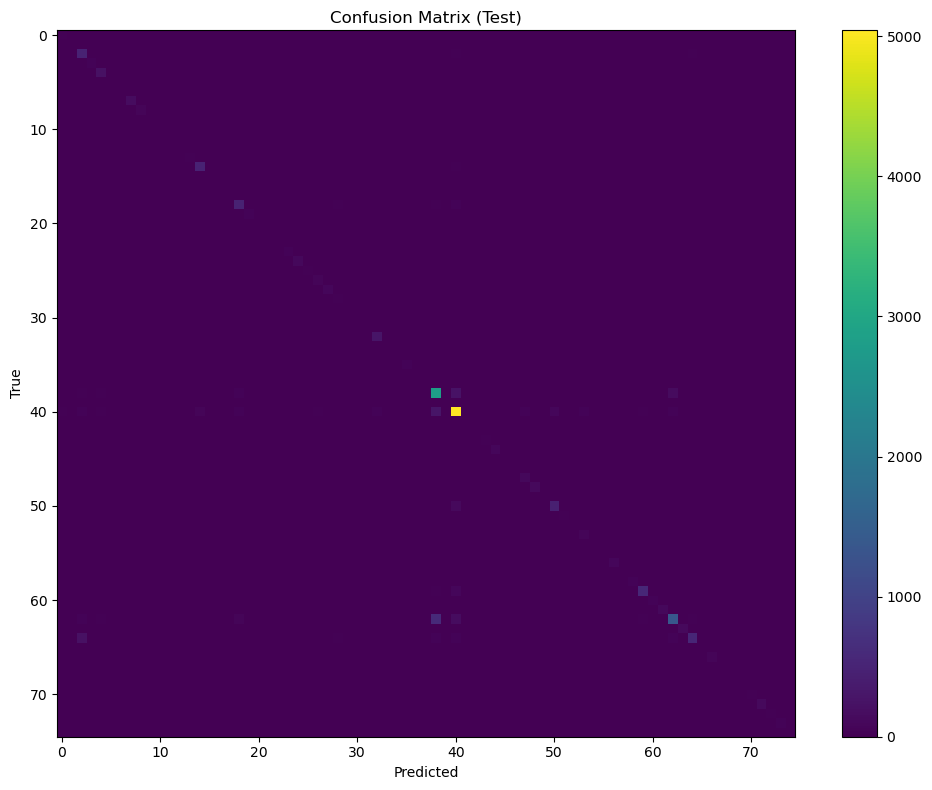

Saved: confusion_matrix_test.png


In [77]:
plt.figure(figsize=(10,8))
plt.imshow(cm, aspect="auto")
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.tight_layout()
plt.savefig("confusion_matrix_test.png", dpi=250)
plt.show()

print("Saved: confusion_matrix_test.png")


In [78]:
20

20

In [79]:
def mc_dropout_predict(m, g1, g2, T=8):
    m.train()  # keep dropout on
    probs_list = []
    with torch.no_grad():
        for _ in range(T):
            with autocast(enabled=use_amp, dtype=amp_dtype):
                logits = m(g1, g2)
            probs_list.append(F.softmax(logits, dim=1))
    probs = torch.stack(probs_list, dim=0).mean(dim=0)
    entropy = -(probs * torch.log(probs + 1e-9)).sum(dim=1)
    m.eval()
    return probs, entropy

print("MC Dropout ready")


MC Dropout ready


In [80]:
21

21

In [81]:
def smiles_fp(smiles, n_bits=1024):
    m = Chem.MolFromSmiles(str(smiles))
    if m is None:
        return None
    return np.array(AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits=n_bits), dtype=np.uint8)

print("Building auditor dataset (TRAIN only)...")
X_aud, y_aud = [], []
for _, r in tqdm(train_df.iterrows(), total=len(train_df), desc="Auditor featurize"):
    fp1 = smiles_fp(r.X1)
    fp2 = smiles_fp(r.X2)
    if fp1 is None or fp2 is None:
        continue
    a, b = sorted([fp1, fp2], key=lambda z: z.tobytes())  # order-invariant
    X_aud.append(np.concatenate([a, b], dtype=np.uint8))
    y_aud.append(int(r.Y))

X_aud = np.asarray(X_aud, dtype=np.uint8)
y_aud = np.asarray(y_aud, dtype=np.int32)
print("Auditor samples:", X_aud.shape)

auditor = RandomForestClassifier(
    n_estimators=200,
    max_depth=24,
    n_jobs=-1,
    random_state=SEED
)
auditor.fit(X_aud, y_aud)
joblib.dump(auditor, "auditor_rf.pkl")
print("Saved auditor_rf.pkl")


Building auditor dataset (TRAIN only)...


Auditor featurize: 100%|██████████████████████████████████████████████████████| 153900/153900 [03:37<00:00, 708.14it/s]


Auditor samples: (153900, 2048)
Saved auditor_rf.pkl


In [87]:
# =========================
# idx-aligned + reproducible audit trail (idx, X1, X2) + sanity checks
# =========================

model.load_state_dict(torch.load(final_ckpt, map_location=device))
model.eval()

class_freq = train_df["Y"].value_counts(normalize=True).to_dict()

# outputs
y_true, y_pred = [], []
reliability, confidence = [], []
entropy_list, auditor_agree_list = [], []

# NEW: audit trail
idx_all, x1_all, x2_all = [], [], []

print("Reliability pass running (idx-aligned)...")

for batch in tqdm(test_loader, desc="Reliability"):
    if batch is None:
        continue

    idx, g1, g2, y = batch

    # ---- idx -> cpu numpy (alignment backbone) ----
    idx_np = idx.detach().cpu().numpy()

    # ---- move graphs ----
    g1 = g1.to(device, non_blocking=True)
    g2 = g2.to(device, non_blocking=True)

    # ---- MC-dropout probs + entropy ----
    probs, ent = mc_dropout_predict(model, g1, g2, T=8)     # probs: torch (B,C) on device, ent: torch (B,) on device
    preds = probs.argmax(1).detach().cpu().numpy()          # (B,)

    # ---- alignment-safe: sub order matches batch order exactly ----
    sub = test_df.iloc[idx_np].reset_index(drop=True)

    # ---- NEW: store mapping for reproducibility ----
    idx_all.extend(idx_np.tolist())
    x1_all.extend(sub["X1"].tolist())
    x2_all.extend(sub["X2"].tolist())

    # ---- auditor features (order-invariant) ----
    X_fp = []
    for _, r in sub.iterrows():
        fp1 = smiles_fp(r.X1)
        fp2 = smiles_fp(r.X2)
        if fp1 is None or fp2 is None:
            fp1 = np.zeros(1024, dtype=np.uint8)
            fp2 = np.zeros(1024, dtype=np.uint8)

        a, b = sorted([fp1, fp2], key=lambda z: z.tobytes())
        X_fp.append(np.concatenate([a, b], dtype=np.uint8))

    aud_preds = None
    if auditor is not None and hasattr(auditor, "predict") and len(X_fp) > 0:
        aud_preds = auditor.predict(np.asarray(X_fp, dtype=np.uint8))  # (B,)

    # ---- reliability score ----
    for i in range(len(sub)):
        pred = int(preds[i])
        pmax = float(probs[i, pred].item())
        e    = float(ent[i].item())

        s = pmax
        s *= math.exp(-e)                                               # uncertainty penalty
        s *= math.exp(-0.5 * (1.0 - float(class_freq.get(pred, 0.0))))   # rarity penalty

        agree = True
        if aud_preds is not None and pred != int(aud_preds[i]):
            s *= 0.6
            agree = False

        reliability.append(float(s))
        confidence.append(float(pmax))
        entropy_list.append(float(e))
        auditor_agree_list.append(int(agree))

    # ---- labels/preds ----
    y_true.extend(y.detach().cpu().tolist())
    y_pred.extend(preds.tolist())

# ---- baseline (no rejection) ----
base_acc = accuracy_score(y_true, y_pred)
base_f1  = f1_score(y_true, y_pred, average="weighted")
print("Baseline (no rejection) acc:", base_acc)
print("Baseline (no rejection) f1 :", base_f1)

# ---- build df (NOW TRACEABLE) ----
df_rel = pd.DataFrame({
    "idx": idx_all,
    "X1": x1_all,
    "X2": x2_all,
    "y_true": y_true,
    "y_pred": y_pred,
    "confidence": confidence,          # MSP
    "entropy": entropy_list,           # MC-dropout entropy
    "auditor_agree": auditor_agree_list,
    "reliability": reliability
})

# ---- sanity checks (publishable proof) ----
assert len(df_rel) == len(y_true) == len(y_pred), "Mismatch: df_rel and y lists lengths differ"
assert df_rel["idx"].is_unique, "Duplicate idx found in reliability pass (should not happen if every sample evaluated once)"
assert len(df_rel) == len(test_df), f"Mismatch: df_rel({len(df_rel)}) != test_df({len(test_df)}). If you dropped None batches, check collate_fn."

# ---- selective prediction proof ----
rows = []
for cov in [1.0, 0.9, 0.8, 0.6, 0.4]:
    k = max(1, int(cov * len(df_rel)))
    top = df_rel.sort_values("reliability", ascending=False).head(k)
    rows.append([
        cov,
        accuracy_score(top.y_true, top.y_pred),
        f1_score(top.y_true, top.y_pred, average="weighted")
    ])

sel_df = pd.DataFrame(rows, columns=["coverage", "accuracy", "weighted_f1"])
print("\nSelective prediction proof (higher reliability → better accuracy/F1):")
print(sel_df)

# ---- save artifacts ----
df_rel.to_csv("reliability_per_sample.csv", index=False)
sel_df.to_csv("selective_prediction.csv", index=False)

cm_rel = confusion_matrix(df_rel.y_true, df_rel.y_pred)
pd.DataFrame(cm_rel).to_csv("confusion_matrix_reliability.csv", index=False)

with open("reliability_metadata.json", "w") as f:
    json.dump({
        "baseline_acc": float(base_acc),
        "baseline_f1": float(base_f1),
        "selective_table": sel_df.to_dict(orient="records"),
        "final_ckpt": str(final_ckpt),
        "T_mc_dropout": 8
    }, f, indent=2)

print("Saved: reliability_per_sample.csv, selective_prediction.csv, confusion_matrix_reliability.csv, reliability_metadata.json")


Reliability pass running (idx-aligned)...


Reliability: 100%|███████████████████████████████████████████████████████████████████| 607/607 [01:50<00:00,  5.50it/s]


Baseline (no rejection) acc: 0.7902436511615928
Baseline (no rejection) f1 : 0.7894732566956539

Selective prediction proof (higher reliability → better accuracy/F1):
   coverage  accuracy  weighted_f1
0       1.0  0.790244     0.789473
1       0.9  0.830347     0.829482
2       0.8  0.858596     0.857498
3       0.6  0.907444     0.906507
4       0.4  0.941017     0.940488
Saved: reliability_per_sample.csv, selective_prediction.csv, confusion_matrix_reliability.csv, reliability_metadata.json


In [89]:
# =========================
# CELL 23 (UPDATED): Calibration metrics (ECE + Brier) on TEST
# Fix: bf16 -> float32 before numpy()
# =========================

def expected_calibration_error_from_probs(probs, y_true, n_bins=15):
    probs = np.asarray(probs, dtype=np.float32)
    y_true = np.asarray(y_true)
    conf = probs.max(axis=1)
    pred = probs.argmax(axis=1)
    acc  = (pred == y_true).astype(np.float32)

    bins = np.linspace(0, 1, n_bins+1)
    ece = 0.0
    for i in range(n_bins):
        m = (conf >= bins[i]) & (conf < bins[i+1])
        if m.sum() == 0:
            continue
        ece += (m.mean()) * abs(acc[m].mean() - conf[m].mean())
    return float(ece)

def brier_score_multiclass(probs, y_true, num_classes):
    probs = np.asarray(probs, dtype=np.float32)
    y_true = np.asarray(y_true)
    onehot = np.zeros((len(y_true), num_classes), dtype=np.float32)
    onehot[np.arange(len(y_true)), y_true] = 1.0
    return float(np.mean(np.sum((probs - onehot)**2, axis=1)))

# ---- Build probs for all test samples (MC-dropout mean probs) ----
all_probs = []
all_y = []

model.eval()
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Collect probs (MC)"):
        if batch is None:
            continue
        idx, g1, g2, y = batch
        g1 = g1.to(device, non_blocking=True)
        g2 = g2.to(device, non_blocking=True)

        probs, _ = mc_dropout_predict(model, g1, g2, T=8)  # mean probs (likely bf16)

        # ---- FIX: bf16 -> fp32 before numpy ----
        probs_np = probs.to(torch.float32).detach().cpu().numpy()
        y_np = y.detach().cpu().numpy()

        all_probs.append(probs_np)
        all_y.append(y_np)

all_probs = np.concatenate(all_probs, axis=0).astype(np.float32)
all_y = np.concatenate(all_y, axis=0)

ece = expected_calibration_error_from_probs(all_probs, all_y, n_bins=15)
brier = brier_score_multiclass(all_probs, all_y, NUM_CLASSES)

print("ECE (15 bins):", ece)
print("Brier score  :", brier)

with open("calibration_metrics.json", "w") as f:
    json.dump({"ECE_15": ece, "Brier": brier, "T_mc_dropout": 8}, f, indent=2)

print("Saved: calibration_metrics.json")


Collect probs (MC): 100%|████████████████████████████████████████████████████████████| 607/607 [00:49<00:00, 12.21it/s]

ECE (15 bins): 0.22239637795668976
Brier score  : 0.3757064938545227
Saved: calibration_metrics.json


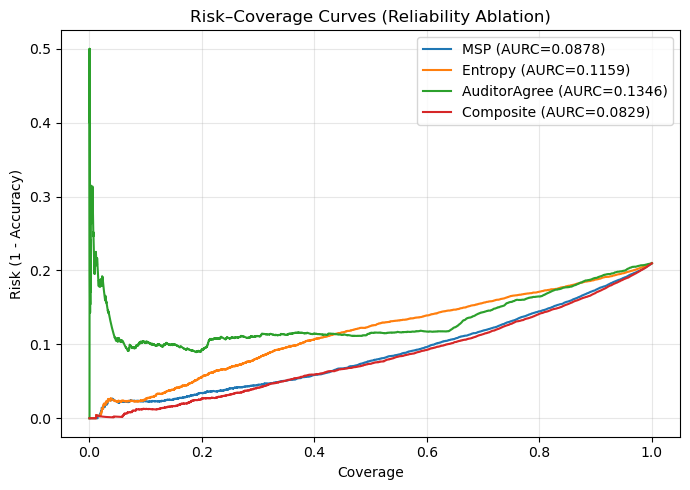

        variant      AURC
3     Composite  0.082926
0           MSP  0.087812
1       Entropy  0.115924
2  AuditorAgree  0.134588
Saved: risk_coverage_ablation.png, aurc_ablation.csv, aurc_ablation.json


In [90]:
# =========================
# CELL 24: Risk–Coverage curves + AURC (ablations)
# =========================

def risk_coverage_curve(y_true, y_pred, score):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    score  = np.asarray(score)

    order = np.argsort(-score)  # higher score = keep
    y_true = y_true[order]
    y_pred = y_pred[order]

    correct = (y_true == y_pred).astype(np.float32)
    cov = np.arange(1, len(correct)+1) / len(correct)
    acc_prefix = np.cumsum(correct) / np.arange(1, len(correct)+1)
    risk = 1.0 - acc_prefix
    return cov, risk

def aurc(cov, risk):
    return float(np.trapz(risk, cov))

ytrue = df_rel["y_true"].values
ypred = df_rel["y_pred"].values

score_msp   = df_rel["confidence"].values
score_ent   = -df_rel["entropy"].values              # lower entropy better
score_aud   = df_rel["auditor_agree"].values.astype(np.float32)
score_comp  = df_rel["reliability"].values

variants = {
    "MSP": score_msp,
    "Entropy": score_ent,
    "AuditorAgree": score_aud,
    "Composite": score_comp
}

aurc_rows = []
plt.figure(figsize=(7,5))
for name, score in variants.items():
    cov, risk = risk_coverage_curve(ytrue, ypred, score)
    a = aurc(cov, risk)
    aurc_rows.append({"variant": name, "AURC": a})
    plt.plot(cov, risk, label=f"{name} (AURC={a:.4f})")

plt.xlabel("Coverage")
plt.ylabel("Risk (1 - Accuracy)")
plt.title("Risk–Coverage Curves (Reliability Ablation)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("risk_coverage_ablation.png", dpi=300)
plt.show()

aurc_df = pd.DataFrame(aurc_rows).sort_values("AURC")
print(aurc_df)

aurc_df.to_csv("aurc_ablation.csv", index=False)
with open("aurc_ablation.json", "w") as f:
    json.dump({r["variant"]: r["AURC"] for r in aurc_rows}, f, indent=2)

print("Saved: risk_coverage_ablation.png, aurc_ablation.csv, aurc_ablation.json")


23

In [91]:
# =========================
# CELL 25: Bootstrap CI for AURC improvements
# =========================

def aurc_from_df(df, score_col):
    cov, risk = risk_coverage_curve(df["y_true"].values, df["y_pred"].values, df[score_col].values)
    return aurc(cov, risk)

def bootstrap_ci_delta(df, col_a, col_b, B=500, seed=42):
    rng = np.random.default_rng(seed)
    n = len(df)
    deltas = []
    idxs = np.arange(n)
    for _ in tqdm(range(B), desc="Bootstrap"):
        samp = rng.choice(idxs, size=n, replace=True)
        d = df.iloc[samp].reset_index(drop=True)
        a = aurc_from_df(d, col_a)
        b = aurc_from_df(d, col_b)
        deltas.append(a - b)  # A - B
    deltas = np.array(deltas)
    return {
        "delta_median": float(np.median(deltas)),
        "ci_2p5": float(np.percentile(deltas, 2.5)),
        "ci_97p5": float(np.percentile(deltas, 97.5)),
        "B": int(B)
    }

# Compare Composite vs MSP (lower AURC is better)
res = bootstrap_ci_delta(df_rel, "reliability", "confidence", B=500, seed=SEED)
print("ΔAURC (Composite - MSP):", res)

with open("bootstrap_aurc_delta.json", "w") as f:
    json.dump(res, f, indent=2)

print("Saved: bootstrap_aurc_delta.json")


Bootstrap: 100%|████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 235.59it/s]

ΔAURC (Composite - MSP): {'delta_median': -0.004964340857028557, 'ci_2p5': -0.006437864096862974, 'ci_97p5': -0.0034046483851167177, 'B': 500}
Saved: bootstrap_aurc_delta.json


In [92]:
# =========================
# CELL 26: Selective prediction tables for baselines vs Composite
# =========================

def selective_table(df, score_col, coverages=(1.0, 0.9, 0.8, 0.6, 0.4)):
    rows = []
    for cov in coverages:
        k = max(1, int(cov * len(df)))
        top = df.sort_values(score_col, ascending=False).head(k)
        rows.append({
            "score": score_col,
            "coverage": cov,
            "accuracy": float(accuracy_score(top.y_true, top.y_pred)),
            "weighted_f1": float(f1_score(top.y_true, top.y_pred, average="weighted"))
        })
    return pd.DataFrame(rows)

df_msp = selective_table(df_rel, "confidence")
df_ent = selective_table(df_rel.assign(ent_score=-df_rel["entropy"]), "ent_score")
df_cmp = selective_table(df_rel, "reliability")

paper_sel = pd.concat([df_msp, df_ent, df_cmp], axis=0).reset_index(drop=True)
print(paper_sel)

paper_sel.to_csv("selective_tables_all.csv", index=False)
print("Saved: selective_tables_all.csv")


          score  coverage  accuracy  weighted_f1
0    confidence       1.0  0.790244     0.789473
1    confidence       0.9  0.826341     0.826321
2    confidence       0.8  0.855312     0.855478
3    confidence       0.6  0.902893     0.903223
4    confidence       0.4  0.941275     0.942066
5     ent_score       1.0  0.790244     0.789473
6     ent_score       0.9  0.812375     0.812281
7     ent_score       0.8  0.828590     0.828591
8     ent_score       0.6  0.861080     0.861117
9     ent_score       0.4  0.893368     0.893672
10  reliability       1.0  0.790244     0.789473
11  reliability       0.9  0.830347     0.829482
12  reliability       0.8  0.858596     0.857498
13  reliability       0.6  0.907444     0.906507
14  reliability       0.4  0.941017     0.940488
Saved: selective_tables_all.csv


In [93]:
# =========================
# CELL 27: Failure analysis (low reliability, wrong predictions)
# =========================

df_rel["is_error"] = (df_rel["y_true"] != df_rel["y_pred"]).astype(int)

worst = df_rel.sort_values("reliability", ascending=True).head(50)
err_rate = worst["is_error"].mean()
print("Error rate in lowest-50 reliability:", float(err_rate))

# show few rows (anonymized: just idx + smiles + y_true/y_pred)
print(worst[["idx","X1","X2","y_true","y_pred","confidence","entropy","auditor_agree","reliability"]].head(10))

worst.to_csv("worst_cases_low_reliability.csv", index=False)
print("Saved: worst_cases_low_reliability.csv")


Error rate in lowest-50 reliability: 0.74
         idx                                                 X1  \
13086  13086                                 N[Pt]1(N)OCC(=O)O1   
1250    1250  [Na+].[Na+].N[C@@H](CC1=CC(I)=C(OC2=CC(I)=C(O)...   
1137    1137  [H][C@]1(C[C@@H]2CC[N@]1C[C@@H]2C=C)[C@H](O)C1...   
14069  14069  [H][C@@]12C[C@]3([H])C[C@@H](CC[C@@]3([H])[C@H...   
1372    1372           CNCCC(OC1=CC=C(C=C1)C(F)(F)F)C1=CC=CC=C1   
1136    1136  [H][C@@]12CCN(C[C@@H]1C=C)[C@]([H])(C2)[C@@H](...   
826      826  FC(F)OC1=C(OCC2CC2)C=C(C=C1)C(=O)NC1=C(Cl)C=NC...   
827      827                                     N[Pt](N)(Cl)Cl   
6662    6662  CCCCCOC1=CC=C(C=C1)C1=CC(=NO1)C1=CC=C(C=C1)C(=...   
1338    1338                                              [Li+]   

                                                      X2  y_true  y_pred  \
13086  CC[C@@]1(O)C(=O)OCC2=C1C=C1N(CC3=CC4=C(C=CC(O)...      40      38   
1250                                             [131I-]      59    

In [94]:
# =========================
# CELL 28: Final artifacts checklist for paper/reviewer
# =========================

artifacts = [
    "ddi_best.pt",
    "ddi_finetuned.pt",
    "ddi_metadata.json",
    "confusion_matrix_test.csv",
    "confusion_matrix_test.png",
    "auditor_rf.pkl",

    "reliability_per_sample.csv",
    "selective_prediction.csv",
    "selective_tables_all.csv",
    "aurc_ablation.csv",
    "aurc_ablation.json",
    "risk_coverage_ablation.png",

    "calibration_metrics.json",
    "bootstrap_aurc_delta.json",
    "confusion_matrix_reliability.csv",
    "worst_cases_low_reliability.csv",
    "reliability_metadata.json"
]

print("=== FINAL ARTIFACTS FOR PAPER ===")
missing = []
for p in artifacts:
    ok = os.path.exists(p)
    print(("✅" if ok else "— "), p)
    if not ok:
        missing.append(p)

print("\nMissing count:", len(missing))
if len(missing):
    print("Missing:", missing)


=== FINAL ARTIFACTS FOR PAPER ===
✅ ddi_best.pt
✅ ddi_finetuned.pt
✅ ddi_metadata.json
✅ confusion_matrix_test.csv
✅ confusion_matrix_test.png
✅ auditor_rf.pkl
✅ reliability_per_sample.csv
✅ selective_prediction.csv
✅ selective_tables_all.csv
✅ aurc_ablation.csv
✅ aurc_ablation.json
✅ risk_coverage_ablation.png
✅ calibration_metrics.json
✅ bootstrap_aurc_delta.json
✅ confusion_matrix_reliability.csv
✅ worst_cases_low_reliability.csv
✅ reliability_metadata.json

Missing count: 0


In [95]:
# =========================
# CELL 29: Save split + leakage proof (paper-friendly)
# =========================
split_proof = {
    "n_train": int(len(train_df)),
    "n_val": int(len(val_df)),
    "n_test": int(len(test_df)),
    "unique_pair_scaffolds": int(df["pair_scaffold"].nunique()),
    "train_scaffold_count": int(len(set(train_df["pair_scaffold"]))),
    "val_scaffold_count": int(len(set(val_df["pair_scaffold"]))),
    "test_scaffold_count": int(len(set(test_df["pair_scaffold"]))),
    "overlap_train_val": int(len(set(train_df["pair_scaffold"]) & set(val_df["pair_scaffold"]))),
    "overlap_train_test": int(len(set(train_df["pair_scaffold"]) & set(test_df["pair_scaffold"]))),
    "overlap_val_test": int(len(set(val_df["pair_scaffold"]) & set(test_df["pair_scaffold"]))),
}

print(split_proof)

with open("split_leakage_proof.json", "w") as f:
    json.dump(split_proof, f, indent=2)

print("Saved: split_leakage_proof.json")


{'n_train': 153900, 'n_val': 18387, 'n_test': 19413, 'unique_pair_scaffolds': 99033, 'train_scaffold_count': 79227, 'val_scaffold_count': 9903, 'test_scaffold_count': 9903, 'overlap_train_val': 0, 'overlap_train_test': 0, 'overlap_val_test': 0}
Saved: split_leakage_proof.json


Spearman corr(reliability, -error): 0.3994356576060112 p: 0.0
   bin  mean_rel  error_rate     n
0    0  0.022998    0.570546  1942
1    1  0.037658    0.395672  1941
2    2  0.049587    0.333849  1941
3    3  0.061712    0.242143  1941
4    4  0.075736    0.186921  1942
5    5  0.091583    0.132406  1941
6    6  0.110902    0.112198  1943
7    7  0.135939    0.070655  1939
8    8  0.180234    0.040701  1941
9    9  0.319586    0.012358  1942


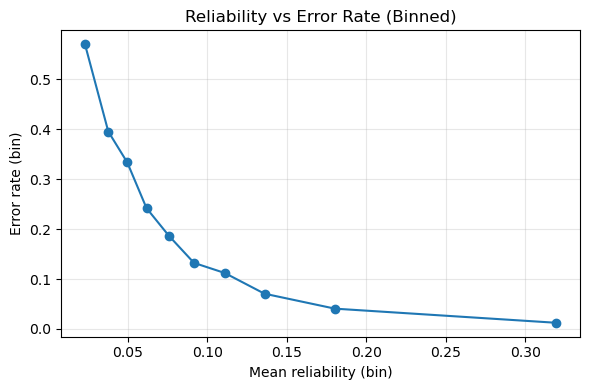

Saved: reliability_bins_error.csv, reliability_bins_error.png, reliability_correlation.json


In [96]:
# =========================
# CELL 30: Reliability monotonicity proof (correlation + bins)
# =========================
from scipy.stats import spearmanr

df_tmp = df_rel.copy()
df_tmp["is_error"] = (df_tmp["y_true"] != df_tmp["y_pred"]).astype(int)

rho, p = spearmanr(df_tmp["reliability"].values, -df_tmp["is_error"].values)  
# negative error => higher reliability should correlate positively

print("Spearman corr(reliability, -error):", float(rho), "p:", float(p))

# binning reliability into deciles
df_tmp["bin"] = pd.qcut(df_tmp["reliability"], q=10, labels=False, duplicates="drop")

bin_stats = df_tmp.groupby("bin").agg(
    mean_rel=("reliability", "mean"),
    error_rate=("is_error", "mean"),
    n=("is_error", "count")
).reset_index()

print(bin_stats)

bin_stats.to_csv("reliability_bins_error.csv", index=False)

plt.figure(figsize=(6,4))
plt.plot(bin_stats["mean_rel"], bin_stats["error_rate"], marker="o")
plt.xlabel("Mean reliability (bin)")
plt.ylabel("Error rate (bin)")
plt.title("Reliability vs Error Rate (Binned)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("reliability_bins_error.png", dpi=300)
plt.show()

with open("reliability_correlation.json", "w") as f:
    json.dump({"spearman_rho": float(rho), "p_value": float(p)}, f, indent=2)

print("Saved: reliability_bins_error.csv, reliability_bins_error.png, reliability_correlation.json")


In [97]:
model.load_state_dict(torch.load(final_ckpt, map_location=device))
model.to(device)
model.eval()

start = time.time()

targets = {
    "coverage": [1.0, 0.9, 0.8, 0.6, 0.4],
    "min_reliability": 0.0,
    "min_confidence": 0.0
}

class_freq = train_df["Y"].value_counts(normalize=True).to_dict()

n_total = 0
n_kept = 0
y_true_all, y_pred_all = [], []
y_true_kept, y_pred_kept = [], []
rel_all, conf_all, ent_all, aud_all = [], [], [], []

torch.cuda.reset_peak_memory_stats() if device.type == "cuda" else None

for batch in tqdm(test_loader, desc="Production demo"):
    if batch is None:
        continue

    idx, g1, g2, y = batch
    idx_np = idx.detach().cpu().numpy()

    g1 = g1.to(device, non_blocking=True)
    g2 = g2.to(device, non_blocking=True)

    probs, ent = mc_dropout_predict(model, g1, g2, T=8)
    probs = probs.float()
    ent = ent.float()
    preds = probs.argmax(1).detach().cpu().numpy()

    sub = test_df.iloc[idx_np].reset_index(drop=True)

    X_fp = []
    for _, r in sub.iterrows():
        fp1 = smiles_fp(r.X1)
        fp2 = smiles_fp(r.X2)
        if fp1 is None or fp2 is None:
            fp1 = np.zeros(1024, dtype=np.uint8)
            fp2 = np.zeros(1024, dtype=np.uint8)
        a, b = sorted([fp1, fp2], key=lambda z: z.tobytes())
        X_fp.append(np.concatenate([a, b], dtype=np.uint8))

    aud_preds = None
    if auditor is not None and hasattr(auditor, "predict") and len(X_fp) > 0:
        aud_preds = auditor.predict(np.asarray(X_fp, dtype=np.uint8))

    for i in range(len(sub)):
        pred = int(preds[i])
        pmax = float(probs[i, pred].item())
        e = float(ent[i].item())

        s = pmax
        s *= math.exp(-e)
        s *= math.exp(-0.5 * (1.0 - float(class_freq.get(pred, 0.0))))

        agree = 1
        if aud_preds is not None and pred != int(aud_preds[i]):
            s *= 0.6
            agree = 0

        yt = int(y[i].item())
        y_true_all.append(yt)
        y_pred_all.append(pred)
        rel_all.append(float(s))
        conf_all.append(float(pmax))
        ent_all.append(float(e))
        aud_all.append(int(agree))

        keep = (s >= targets["min_reliability"]) and (pmax >= targets["min_confidence"])
        if keep:
            y_true_kept.append(yt)
            y_pred_kept.append(pred)
            n_kept += 1

        n_total += 1

df_demo = pd.DataFrame({
    "y_true": y_true_all,
    "y_pred": y_pred_all,
    "reliability": rel_all,
    "confidence": conf_all,
    "entropy": ent_all,
    "auditor_agree": aud_all
})

base_acc = float(accuracy_score(df_demo.y_true, df_demo.y_pred))
base_f1  = float(f1_score(df_demo.y_true, df_demo.y_pred, average="weighted"))

sel_rows = []
for cov in targets["coverage"]:
    k = max(1, int(cov * len(df_demo)))
    top = df_demo.sort_values("reliability", ascending=False).head(k)
    sel_rows.append({
        "coverage": float(cov),
        "kept_n": int(k),
        "accuracy": float(accuracy_score(top.y_true, top.y_pred)),
        "weighted_f1": float(f1_score(top.y_true, top.y_pred, average="weighted"))
    })

sel = pd.DataFrame(sel_rows)

latency_sec = time.time() - start
peak_mem_mb = None
if device.type == "cuda":
    peak_mem_mb = float(torch.cuda.max_memory_allocated() / (1024**2))

out = {
    "checkpoint": str(final_ckpt),
    "device": str(device),
    "torch": str(torch.__version__),
    "num_classes": int(NUM_CLASSES),
    "test_samples": int(n_total),
    "baseline_accuracy": base_acc,
    "baseline_weighted_f1": base_f1,
    "selective_table": sel_rows,
    "latency_seconds_total": float(latency_sec),
    "latency_ms_per_sample": float(1000.0 * latency_sec / max(1, n_total)),
    "gpu_peak_memory_mb": peak_mem_mb
}

print(json.dumps(out, indent=2))

df_demo.to_csv("production_demo_predictions.csv", index=False)
sel.to_csv("production_demo_selective_table.csv", index=False)
with open("production_demo_report.json", "w") as f:
    json.dump(out, f, indent=2)

print("Saved: production_demo_predictions.csv, production_demo_selective_table.csv, production_demo_report.json")


Production demo: 100%|███████████████████████████████████████████████████████████████| 607/607 [01:51<00:00,  5.45it/s]


{
  "checkpoint": "ddi_finetuned.pt",
  "device": "cuda",
  "torch": "2.1.2+cu121",
  "num_classes": 76,
  "test_samples": 19413,
  "baseline_accuracy": 0.7861227012826456,
  "baseline_weighted_f1": 0.7854228333137433,
  "selective_table": [
    {
      "coverage": 1.0,
      "kept_n": 19413,
      "accuracy": 0.7861227012826456,
      "weighted_f1": 0.7854228333137433
    },
    {
      "coverage": 0.9,
      "kept_n": 17471,
      "accuracy": 0.8274283097704768,
      "weighted_f1": 0.8262107060306618
    },
    {
      "coverage": 0.8,
      "kept_n": 15530,
      "accuracy": 0.8573728267868641,
      "weighted_f1": 0.8558682971235511
    },
    {
      "coverage": 0.6,
      "kept_n": 11647,
      "accuracy": 0.9050399244440629,
      "weighted_f1": 0.9040123545060567
    },
    {
      "coverage": 0.4,
      "kept_n": 7765,
      "accuracy": 0.9437218287186091,
      "weighted_f1": 0.9434691735463518
    }
  ],
  "latency_seconds_total": 111.48039078712463,
  "latency_ms_per_sampl

In [98]:
def collect_mc_probs_and_preds(model, loader, T=8):
    model.eval()
    all_probs, all_y, all_pred = [], [], []
    t0 = time.time()
    with torch.no_grad():
        for batch in tqdm(loader, desc=f"Collect probs (MC, T={T})"):
            if batch is None:
                continue
            idx, g1, g2, y = batch
            g1 = g1.to(device, non_blocking=True)
            g2 = g2.to(device, non_blocking=True)

            probs, _ = mc_dropout_predict(model, g1, g2, T=T)
            probs_np = probs.to(torch.float32).detach().cpu().numpy()
            y_np = y.detach().cpu().numpy()

            all_probs.append(probs_np)
            all_y.append(y_np)
            all_pred.append(probs_np.argmax(axis=1))
    dt = time.time() - t0
    all_probs = np.concatenate(all_probs, axis=0).astype(np.float32)
    all_y = np.concatenate(all_y, axis=0)
    all_pred = np.concatenate(all_pred, axis=0)
    return all_probs, all_y, all_pred, dt

def risk_coverage_curve_from_probs(y_true, y_pred, score):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    score  = np.asarray(score)
    order = np.argsort(-score)
    y_true = y_true[order]; y_pred = y_pred[order]
    correct = (y_true == y_pred).astype(np.float32)
    cov = np.arange(1, len(correct)+1) / len(correct)
    acc_prefix = np.cumsum(correct) / np.arange(1, len(correct)+1)
    risk = 1.0 - acc_prefix
    return cov, risk

def aurc(cov, risk):
    return float(np.trapz(risk, cov))

def expected_calibration_error_from_probs(probs, y_true, n_bins=15):
    probs = np.asarray(probs, dtype=np.float32)
    y_true = np.asarray(y_true)
    conf = probs.max(axis=1)
    pred = probs.argmax(axis=1)
    acc  = (pred == y_true).astype(np.float32)

    bins = np.linspace(0, 1, n_bins+1)
    ece = 0.0
    for i in range(n_bins):
        m = (conf >= bins[i]) & (conf < bins[i+1])
        if m.sum() == 0:
            continue
        ece += (m.mean()) * abs(acc[m].mean() - conf[m].mean())
    return float(ece)

def brier_score_multiclass(probs, y_true, num_classes):
    probs = np.asarray(probs, dtype=np.float32)
    y_true = np.asarray(y_true)
    onehot = np.zeros((len(y_true), num_classes), dtype=np.float32)
    onehot[np.arange(len(y_true)), y_true] = 1.0
    return float(np.mean(np.sum((probs - onehot)**2, axis=1)))

Ts = [4, 8, 16]
rows = []
for T in Ts:
    probs, y, pred, dt = collect_mc_probs_and_preds(model, test_loader, T=T)
    acc = float(accuracy_score(y, pred))
    wf1 = float(f1_score(y, pred, average="weighted"))
    conf = probs.max(axis=1)  # MSP under MC mean probs
    cov, risk = risk_coverage_curve_from_probs(y, pred, conf)
    AURC = aurc(cov, risk)

    ece = expected_calibration_error_from_probs(probs, y, n_bins=15)
    brier = brier_score_multiclass(probs, y, NUM_CLASSES)

    rows.append({
        "T": int(T),
        "test_acc": acc,
        "test_weighted_f1": wf1,
        "AURC_MSP_from_MCmean": float(AURC),
        "ECE_15": float(ece),
        "Brier": float(brier),
        "runtime_seconds": float(dt),
        "ms_per_sample": float(1000.0 * dt / len(y))
    })

mcT_df = pd.DataFrame(rows)
print(mcT_df)

mcT_df.to_csv("mcT_sensitivity.csv", index=False)
with open("mcT_sensitivity.json", "w") as f:
    json.dump(rows, f, indent=2)

print("Saved: mcT_sensitivity.csv, mcT_sensitivity.json")

Collect probs (MC, T=16): 100%|██████████████████████████████████████████████████████| 607/607 [01:36<00:00,  6.26it/s]

    T  test_acc  test_weighted_f1  AURC_MSP_from_MCmean    ECE_15     Brier  \
0   4  0.777417          0.776877              0.095693  0.207411  0.383225   
1   8  0.788544          0.787939              0.088316  0.222235  0.376651   
2  16  0.794262          0.793680              0.083675  0.229744  0.373048   

   runtime_seconds  ms_per_sample  
0        27.244540       1.403417  
1        50.655938       2.609382  
2        96.988153       4.996041  
Saved: mcT_sensitivity.csv, mcT_sensitivity.json


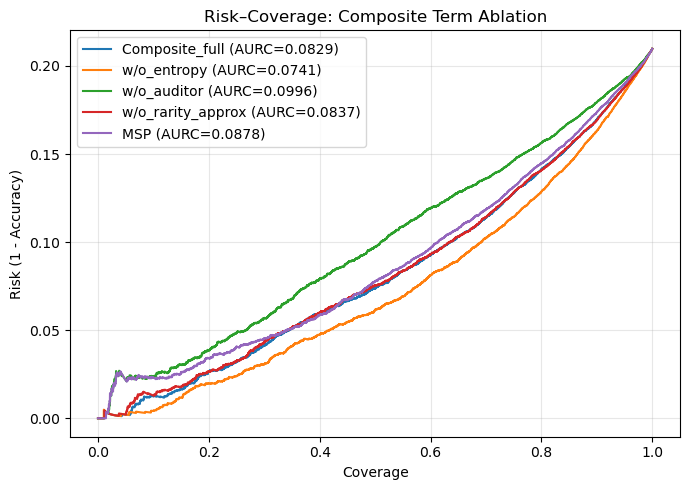

             variant      AURC
1        w/o_entropy  0.074100
0     Composite_full  0.082926
3  w/o_rarity_approx  0.083652
4                MSP  0.087812
2        w/o_auditor  0.099613
Saved: composite_term_ablation.csv, composite_term_ablation.png, composite_term_ablation.json


In [99]:
def risk_coverage_curve(y_true, y_pred, score):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    score  = np.asarray(score)
    order = np.argsort(-score)
    y_true = y_true[order]
    y_pred = y_pred[order]
    correct = (y_true == y_pred).astype(np.float32)
    cov = np.arange(1, len(correct)+1) / len(correct)
    acc_prefix = np.cumsum(correct) / np.arange(1, len(correct)+1)
    risk = 1.0 - acc_prefix
    return cov, risk

def aurc(cov, risk):
    return float(np.trapz(risk, cov))

ytrue = df_rel["y_true"].values
ypred = df_rel["y_pred"].values

conf = df_rel["confidence"].values.astype(np.float32)
ent  = df_rel["entropy"].values.astype(np.float32)
aud  = df_rel["auditor_agree"].values.astype(np.float32)
comp = df_rel["reliability"].values.astype(np.float32)

# --- Term-drop scores ---
# w/o entropy: remove uncertainty penalty
score_wo_entropy = conf * (0.6 + 0.4*aud)    # keep auditor effect only (agree=1 =>1.0, disagree=0=>0.6)

# w/o auditor: remove auditor penalty
score_wo_auditor = conf * np.exp(-ent)

# w/o "rarity" approx: use confidence*exp(-entropy) plus auditor factor (no extra class balancing)
score_wo_rarity_approx = conf * np.exp(-ent) * (0.6 + 0.4*aud)

variants = {
    "Composite_full": comp,
    "w/o_entropy": score_wo_entropy,
    "w/o_auditor": score_wo_auditor,
    "w/o_rarity_approx": score_wo_rarity_approx,
    "MSP": conf
}

rows = []
plt.figure(figsize=(7,5))
for name, score in variants.items():
    cov, risk = risk_coverage_curve(ytrue, ypred, score)
    a = aurc(cov, risk)
    rows.append({"variant": name, "AURC": a})
    plt.plot(cov, risk, label=f"{name} (AURC={a:.4f})")

plt.xlabel("Coverage")
plt.ylabel("Risk (1 - Accuracy)")
plt.title("Risk–Coverage: Composite Term Ablation")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("composite_term_ablation.png", dpi=300)
plt.show()

ab_df = pd.DataFrame(rows).sort_values("AURC")
print(ab_df)

ab_df.to_csv("composite_term_ablation.csv", index=False)
with open("composite_term_ablation.json", "w") as f:
    json.dump(rows, f, indent=2)

print("Saved: composite_term_ablation.csv, composite_term_ablation.png, composite_term_ablation.json")

In [110]:
import numpy as np, json, math
from tqdm import tqdm
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

FP_BITS = 1024
fp_cache = {}

def smiles_fp_cached(smiles, n_bits=FP_BITS):
    s = str(smiles)
    if s in fp_cache:
        return fp_cache[s]
    m = Chem.MolFromSmiles(s)
    if m is None:
        fp_cache[s] = None
        return None
    v = np.array(AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits=n_bits), dtype=np.uint8)
    fp_cache[s] = v
    return v

def pair_fp_from_row(row):
    fp1 = smiles_fp_cached(row.X1)
    fp2 = smiles_fp_cached(row.X2)
    if fp1 is None or fp2 is None:
        return None
    a, b = (fp1, fp2) if fp1.tobytes() <= fp2.tobytes() else (fp2, fp1)
    return np.concatenate([a, b], dtype=np.uint8)

def batch_iter_frame(frame, batch_size=4096):
    Xb, yb = [], []
    for _, r in frame.iterrows():
        v = pair_fp_from_row(r)
        if v is None:
            continue
        Xb.append(v)
        yb.append(int(r.Y))
        if len(Xb) >= batch_size:
            Xb = np.asarray(Xb, dtype=np.uint8)
            yb = np.asarray(yb, dtype=np.int32)
            yield Xb, yb
            Xb, yb = [], []
    if len(Xb):
        Xb = np.asarray(Xb, dtype=np.uint8)
        yb = np.asarray(yb, dtype=np.int32)
        yield Xb, yb

# ---- Model (streaming) ----
clf = SGDClassifier(
    loss="log_loss",
    alpha=1e-5,
    learning_rate="optimal",
    max_iter=1,     # IMPORTANT: we control epochs ourselves via partial_fit
    tol=None,
    random_state=SEED
)

classes = np.arange(NUM_CLASSES, dtype=np.int32)

EPOCHS = 2          # 2-3 is enough for baseline; keep fast
BATCH = 4096        # tune 2048/4096 depending RAM

print("Training streaming SGD baseline...")
for ep in range(1, EPOCHS+1):
    n_seen = 0
    for X_u8, y in tqdm(batch_iter_frame(train_df, batch_size=BATCH), desc=f"SGD train epoch {ep}/{EPOCHS}"):
        # batch float32 only (small memory)
        X = X_u8.astype(np.float32, copy=False)
        if ep == 1 and n_seen == 0:
            clf.partial_fit(X, y, classes=classes)
        else:
            clf.partial_fit(X, y)
        n_seen += len(y)
    print(f"  epoch {ep} done | seen: {n_seen}")

# ---- Evaluate on test (batch prediction) ----
print("Evaluating on TEST...")
y_true, y_pred = [], []

for X_u8, y in tqdm(batch_iter_frame(test_df, batch_size=BATCH), desc="SGD test"):
    X = X_u8.astype(np.float32, copy=False)
    p = clf.predict(X)
    y_true.extend(y.tolist())
    y_pred.extend(p.tolist())

acc = float(accuracy_score(y_true, y_pred))
wf1 = float(f1_score(y_true, y_pred, average="weighted"))
mf1 = float(f1_score(y_true, y_pred, average="macro"))

print("Streaming SGD baseline | acc:", acc, "| weighted_f1:", wf1, "| macro_f1:", mf1)

rep = classification_report(y_true, y_pred)
with open("sgd_stream_baseline_report.txt", "w") as f:
    f.write(rep)

out = {
    "model": "Streaming SGD Logistic (partial_fit) on Morgan FP pair concat (order-invariant)",
    "fp_bits_per_drug": int(FP_BITS),
    "feature_dim": int(2*FP_BITS),
    "epochs": int(EPOCHS),
    "batch_size": int(BATCH),
    "alpha": 1e-5,
    "test_accuracy": acc,
    "test_weighted_f1": wf1,
    "test_macro_f1": mf1,
    "seed": int(SEED)
}
with open("sgd_stream_baseline_metrics.json", "w") as f:
    json.dump(out, f, indent=2)

print("Saved: sgd_stream_baseline_metrics.json, sgd_stream_baseline_report.txt")


Training streaming SGD baseline...


SGD train epoch 1/2: 38it [00:54,  1.44s/it]


  epoch 1 done | seen: 153900


SGD train epoch 2/2: 38it [00:51,  1.37s/it]


  epoch 2 done | seen: 153900
Evaluating on TEST...


SGD test: 5it [00:01,  3.70it/s]

Streaming SGD baseline | acc: 0.5673002627105548 | weighted_f1: 0.5729059021059824 | macro_f1: 0.3284200883746488
Saved: sgd_stream_baseline_metrics.json, sgd_stream_baseline_report.txt


In [111]:
import json, pandas as pd, os

def load_json(path):
    with open(path, "r") as f:
        return json.load(f)

# --- Load baseline ---
base = load_json("sgd_stream_baseline_metrics.json")

# --- Load GNN ---
gnn = load_json("ddi_metadata.json")

# --- Load selective table (prefer production demo if exists) ---
sel = None
if os.path.exists("production_demo_report.json"):
    sel = load_json("production_demo_report.json")["selective_table"]
elif os.path.exists("reliability_metadata.json"):
    sel = load_json("reliability_metadata.json")["selective_table"]
else:
    sel = None

rows = []

# Baseline row
rows.append({
    "Model": "MorganFP + SGD (baseline)",
    "Accuracy": base.get("test_accuracy", None),
    "Weighted_F1": base.get("test_weighted_f1", None),
    "Macro_F1": base.get("test_macro_f1", None),
    "Coverage": 1.0
})

# GNN row (full coverage)
rows.append({
    "Model": "GNN (Siamese GATv2) - full",
    "Accuracy": gnn.get("test_accuracy", None),
    "Weighted_F1": gnn.get("test_weighted_f1", None),
    "Macro_F1": None,
    "Coverage": 1.0
})

# Selective rows 
if sel is not None:
    for r in sel:
        rows.append({
            "Model": "GNN + Reliability (selective)",
            "Accuracy": r["accuracy"],
            "Weighted_F1": r["weighted_f1"],
            "Macro_F1": None,
            "Coverage": r["coverage"]
        })

df_tab = pd.DataFrame(rows)

# nice formatting
df_tab["Accuracy"] = df_tab["Accuracy"].astype(float).round(4)
df_tab["Weighted_F1"] = df_tab["Weighted_F1"].astype(float).round(4)
df_tab["Coverage"] = df_tab["Coverage"].astype(float).round(2)

df_tab.to_csv("paper_main_table.csv", index=False)

latex = df_tab.to_latex(index=False, escape=True)
with open("paper_main_table.tex", "w") as f:
    f.write(latex)

print(df_tab)
print("\nSaved: paper_main_table.csv, paper_main_table.tex")

                           Model  Accuracy  Weighted_F1  Macro_F1  Coverage
0      MorganFP + SGD (baseline)    0.5673       0.5729   0.32842       1.0
1     GNN (Siamese GATv2) - full    0.7741       0.7744       NaN       1.0
2  GNN + Reliability (selective)    0.7861       0.7854       NaN       1.0
3  GNN + Reliability (selective)    0.8274       0.8262       NaN       0.9
4  GNN + Reliability (selective)    0.8574       0.8559       NaN       0.8
5  GNN + Reliability (selective)    0.9050       0.9040       NaN       0.6
6  GNN + Reliability (selective)    0.9437       0.9435       NaN       0.4

Saved: paper_main_table.csv, paper_main_table.tex


In [113]:
import shutil, os

src = "risk_coverage_ablation.png"
dst = "fig_risk_coverage.png"

assert os.path.exists(src), f"Missing {src}"
shutil.copy(src, dst)
print("Saved:", dst)

Saved: fig_risk_coverage.png


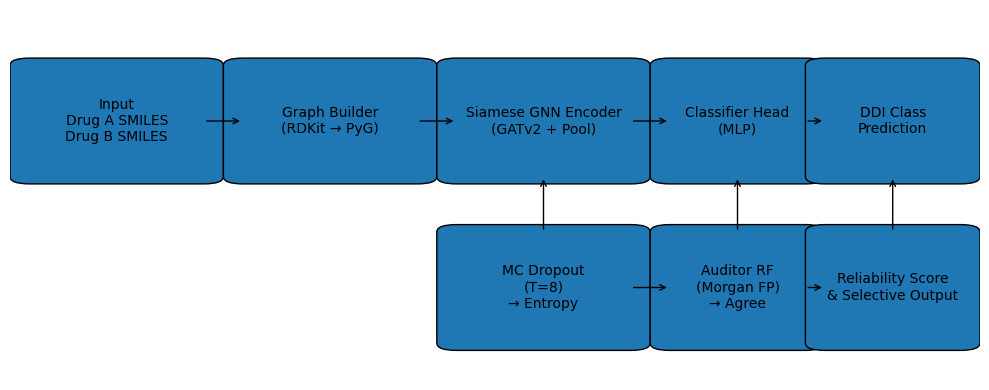

Saved: fig_architecture.png


In [115]:
# =========================
#   - fig_architecture.png
# =========================

import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch

def box(ax, x, y, w, h, text):
    p = FancyBboxPatch(
        (x, y), w, h,
        boxstyle="round,pad=0.02,rounding_size=0.02",
        linewidth=1
    )
    ax.add_patch(p)
    ax.text(x + w/2, y + h/2, text,
            ha="center", va="center", fontsize=10)

plt.figure(figsize=(10,4))
ax = plt.gca()
ax.set_axis_off()

# ---- Top pipeline ----
box(ax, 0.02, 0.55, 0.18, 0.3, "Input\nDrug A SMILES\nDrug B SMILES")
box(ax, 0.24, 0.55, 0.18, 0.3, "Graph Builder\n(RDKit → PyG)")
box(ax, 0.46, 0.55, 0.18, 0.3, "Siamese GNN Encoder\n(GATv2 + Pool)")
box(ax, 0.68, 0.55, 0.14, 0.3, "Classifier Head\n(MLP)")
box(ax, 0.84, 0.55, 0.14, 0.3, "DDI Class\nPrediction")

# ---- Reliability branch ----
box(ax, 0.46, 0.10, 0.18, 0.30, "MC Dropout\n(T=8)\n→ Entropy")
box(ax, 0.68, 0.10, 0.14, 0.30, "Auditor RF\n(Morgan FP)\n→ Agree")
box(ax, 0.84, 0.10, 0.14, 0.30, "Reliability Score\n& Selective Output")

# ---- Arrows (top flow) ----
ax.annotate("", xy=(0.24,0.70), xytext=(0.20,0.70), arrowprops=dict(arrowstyle="->"))
ax.annotate("", xy=(0.46,0.70), xytext=(0.42,0.70), arrowprops=dict(arrowstyle="->"))
ax.annotate("", xy=(0.68,0.70), xytext=(0.64,0.70), arrowprops=dict(arrowstyle="->"))
ax.annotate("", xy=(0.84,0.70), xytext=(0.82,0.70), arrowprops=dict(arrowstyle="->"))

# ---- Downward arrows to reliability ----
ax.annotate("", xy=(0.55,0.55), xytext=(0.55,0.40), arrowprops=dict(arrowstyle="->"))
ax.annotate("", xy=(0.75,0.55), xytext=(0.75,0.40), arrowprops=dict(arrowstyle="->"))
ax.annotate("", xy=(0.91,0.55), xytext=(0.91,0.40), arrowprops=dict(arrowstyle="->"))

# ---- Bottom flow ----
ax.annotate("", xy=(0.68,0.25), xytext=(0.64,0.25), arrowprops=dict(arrowstyle="->"))
ax.annotate("", xy=(0.84,0.25), xytext=(0.82,0.25), arrowprops=dict(arrowstyle="->"))

plt.tight_layout()
plt.savefig("fig_architecture.png", dpi=300)
plt.show()

print("Saved: fig_architecture.png")


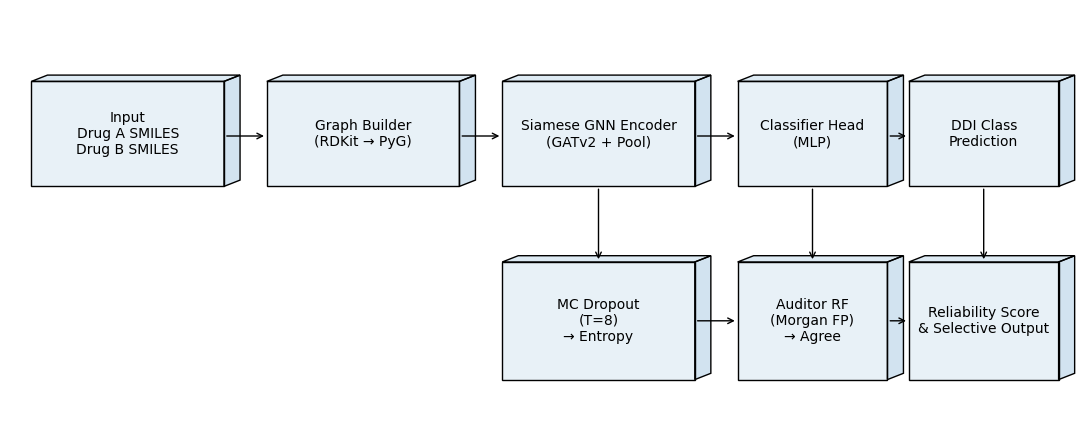

Saved: fig_architecture_3dlook.png


In [117]:
from matplotlib.patches import Polygon

def draw_3d_box(ax, x, y, w, h, depth=0.015, label=""):
    """
    Pseudo-3D box: front face + top face + side face
    Coordinates in axes fraction (0..1)
    """
    # front face
    front = np.array([
        [x, y],
        [x+w, y],
        [x+w, y+h],
        [x, y+h]
    ])

    # offset for depth (diagonal up-right)
    dx, dy = depth, depth

    # top face
    top = np.array([
        [x, y+h],
        [x+w, y+h],
        [x+w+dx, y+h+dy],
        [x+dx, y+h+dy]
    ])

    # side face (right)
    side = np.array([
        [x+w, y],
        [x+w, y+h],
        [x+w+dx, y+h+dy],
        [x+w+dx, y+dy]
    ])

    # Draw faces (no explicit colors specified; matplotlib will default.
    # To keep paper-friendly, we use grayscale-like alpha via edge-only + light fill.
    ax.add_patch(Polygon(top, closed=True, alpha=0.15))
    ax.add_patch(Polygon(side, closed=True, alpha=0.20))
    ax.add_patch(Polygon(front, closed=True, alpha=0.10))

    # borders
    ax.add_patch(Polygon(front, closed=True, fill=False, linewidth=1))
    ax.add_patch(Polygon(top, closed=True, fill=False, linewidth=1))
    ax.add_patch(Polygon(side, closed=True, fill=False, linewidth=1))

    # label
    ax.text(x + w/2, y + h/2, label, ha="center", va="center", fontsize=10)

def arrow(ax, x1, y1, x2, y2):
    ax.annotate("", xy=(x2,y2), xytext=(x1,y1),
                arrowprops=dict(arrowstyle="->", linewidth=1))

plt.figure(figsize=(11,4.5))
ax = plt.gca()
ax.set_axis_off()
ax.set_xlim(0,1)
ax.set_ylim(0,1)

# ---- Top pipeline (3D look) ----
draw_3d_box(ax, 0.02, 0.58, 0.18, 0.25, label="Input\nDrug A SMILES\nDrug B SMILES")
draw_3d_box(ax, 0.24, 0.58, 0.18, 0.25, label="Graph Builder\n(RDKit → PyG)")
draw_3d_box(ax, 0.46, 0.58, 0.18, 0.25, label="Siamese GNN Encoder\n(GATv2 + Pool)")
draw_3d_box(ax, 0.68, 0.58, 0.14, 0.25, label="Classifier Head\n(MLP)")
draw_3d_box(ax, 0.84, 0.58, 0.14, 0.25, label="DDI Class\nPrediction")

# ---- Reliability branch ----
draw_3d_box(ax, 0.46, 0.12, 0.18, 0.28, label="MC Dropout\n(T=8)\n→ Entropy")
draw_3d_box(ax, 0.68, 0.12, 0.14, 0.28, label="Auditor RF\n(Morgan FP)\n→ Agree")
draw_3d_box(ax, 0.84, 0.12, 0.14, 0.28, label="Reliability Score\n& Selective Output")

# ---- Arrows (top flow) ----
arrow(ax, 0.20, 0.70, 0.24, 0.70)
arrow(ax, 0.42, 0.70, 0.46, 0.70)
arrow(ax, 0.64, 0.70, 0.68, 0.70)
arrow(ax, 0.82, 0.70, 0.84, 0.70)

# ---- Down arrows into reliability ----
arrow(ax, 0.55, 0.58, 0.55, 0.40)  # from encoder to MC dropout
arrow(ax, 0.75, 0.58, 0.75, 0.40)  # from head/pred to auditor agree
arrow(ax, 0.91, 0.58, 0.91, 0.40)  # to final selective output

# ---- Bottom flow ----
arrow(ax, 0.64, 0.26, 0.68, 0.26)
arrow(ax, 0.82, 0.26, 0.84, 0.26)

plt.tight_layout()
plt.savefig("fig_architecture_3dlook.png", dpi=300)
plt.show()

print("Saved: fig_architecture_3dlook.png")


In [119]:


import os, zipfile
src = "reliability_bins_error.png"
dst = "fig_reliability_vs_error.png"

if os.path.exists(src) and (not os.path.exists(dst)):
    shutil.copy(src, dst)

print("Ready:", os.path.exists(dst), dst)
must_files = [
    # core model + split proof
    "ddi_best.pt",
    "ddi_finetuned.pt",
    "ddi_metadata.json",
    "split_leakage_proof.json",

    # test metrics
    "confusion_matrix_test.csv",
    "confusion_matrix_test.png",

    # reliability artifacts
    "reliability_per_sample.csv",
    "selective_prediction.csv",
    "selective_tables_all.csv",
    "aurc_ablation.csv",
    "aurc_ablation.json",
    "risk_coverage_ablation.png",
    "calibration_metrics.json",
    "bootstrap_aurc_delta.json",
    "reliability_metadata.json",
    "reliability_bins_error.csv",
    "reliability_correlation.json",

    # baseline
    "sgd_stream_baseline_metrics.json",
    "sgd_stream_baseline_report.txt",

    # paper tables + figs (from above cells)
    "paper_main_table.csv",
    "paper_main_table.tex",
    "fig_architecture.png",
    "fig_risk_coverage.png",
    "fig_reliability_vs_error.png",
]

missing = [f for f in must_files if not os.path.exists(f)]
print("Missing:", missing)

zip_name = "Artifacts packaged.zip"
with zipfile.ZipFile(zip_name, "w", compression=zipfile.ZIP_DEFLATED) as z:
    for f in must_files:
        if os.path.exists(f):
            z.write(f)

print("Saved:", zip_name)


Ready: True fig_reliability_vs_error.png
Missing: []
Saved: Artifacts packaged.zip
